# Monoaural source separation using NMF with Frobenius norm

In the associated paper, an analysis of the separation of sources using the Frobenius norm, KL divergence and the proposed algorithm is provided. In this, we perform separatiion using only the Frobenius norm, using the scikit learn implementation and the local implementation in tools.py.

In [14]:
import os
from os import listdir
from os.path import join
import sys

import librosa
import librosa.display
from librosa.core import resample
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.io.wavfile import write
from sklearn.decomposition import NMF


# relative imports as the directory structure is
# blah-blah/source_separation/examples,
# blah-blah/source_separation/nmf,
sys.path.insert(0,"../../source_separation/")
from nmf.nmf_local import *
from tools.basic_functions import *


figsize = (10,8)
matplotlib.rcParams.update({'font.size': 22})

In [15]:
path_audio = "orig4.wav"
path_rescaled_components = "orig4_rescaled/"

# The audio signal

The audio is created by mixing 7 different instruments. The time domain signal is displayed below. A few notes regarding the implementation:
* Librosa makes several inherent assumptions regarding the signal. It usually defaults to a 22.5kHz sampling rate and some other default hopsizes and so forth.
* It is therefore prudent to set the sampling rate and all the other parameters for each function being used carefully and manually.
* Librosa is still used regardless of this caveat because it has a rich variety of tools for the purpose of audio signal processing that come very much in handy. 
* The sampling rate for all the audios provided by the author is 44.1 kHz. 
* Further, SciPy scales the audios to make all the samples integer valued. Librosa does not.
* All audio used here is single channel and hence loaded as mono.

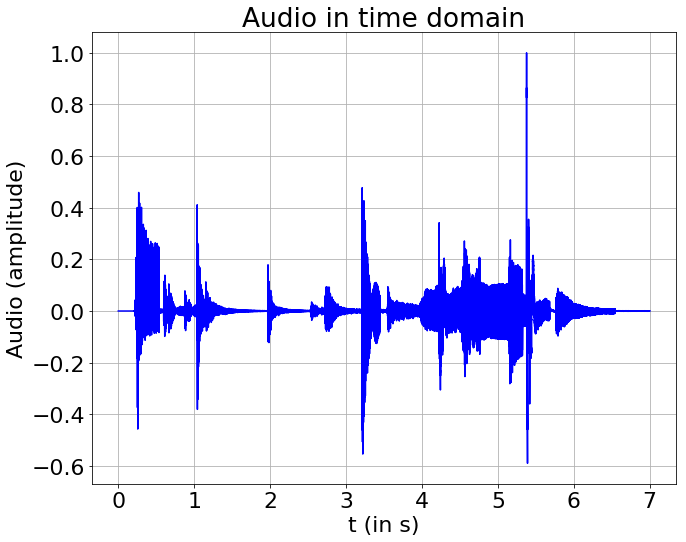

In [16]:
# loading audios
fs_target = 44100
audio, fs = librosa.load(path_audio,sr = fs_target)
# time domain representation
x = np.arange(len(audio))/fs_target
plotfigure(figsize, "t (in s)", "Audio (amplitude)", "Audio in time domain",x,audio,style= "b-" )

The parameters are set using the values provided in the paper [1].

In [17]:
# fft details in time units
frame_size = 40e-3
overlap = 0.5
dft_size = frame_size

# fft details in terms of samples
n_fft = int(frame_size*fs_target) # datatype is an advantage for future use
hop_length = int((1-overlap)*frame_size*fs_target)

# DECISION MADE HERE! for window, center, and reflect 
window = scipy.signal.hann(n_fft)

# The spectrogram

We obtain a STFT using the specifications provided in [1]. Thus we use a frame size of 40ms and a hop length of 20ms. The sampling rate is 44,100 Hz. A hann window is used for the STFT. It is not clear why the author has chosen to use a Hann window. This remains to be seen. 

A few notes and TODOs regarding the implementation:
* Librosa assumes a number of default values in the case of the STFT extraction and the display. For instance, it uses a default sampling rate of 22.5kHz in the display function leading to incorrect frequency axis range. This has to be set to desired sampling frequency rate.
* An experimentation with the center value in librosa needs to be done.
* SciPy uses zero padding whereas librosa uses reflection padding. It remains to be seen how each of these affects the final output.

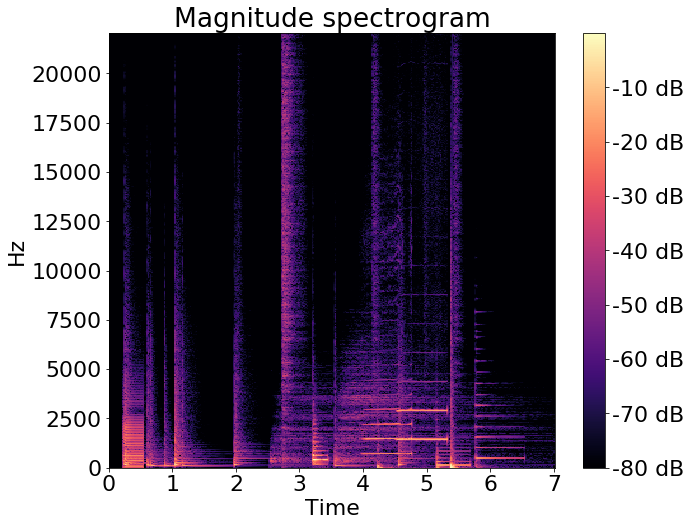

In [19]:
spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length, window = scipy.signal.hann(n_fft))#, center= True )
D = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time', sr = fs_target, hop_length = n_fft/2)
plt.colorbar(format='%+2.0f dB')
plt.title("Magnitude spectrogram")
plt.show()

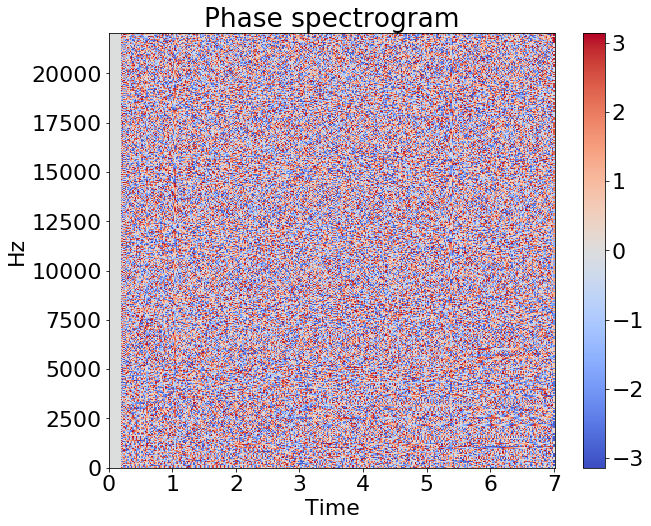

In [37]:
E = np.angle(spec, deg = 0)
plt.figure(figsize=figsize)
librosa.display.specshow(E, y_axis='linear', x_axis='time', sr = fs_target, hop_length = n_fft/2)
plt.title("Phase spectrogram")
plt.colorbar()
plt.show()

# The NMF

We now factorize the magnitude spectrogram using NMF. Ideally, the number of components is determined empirically, by studying the SVD and so forth. However, in this initial implementation, it is assumed that 7 underlying components exist as we already know that the audio was created by mixing 7. This makes the implementation quite easy. The use of more number of components shall be explored in greater depth later.

The Frobenius norm is minimised using the MU rules as the final algorithm depends on MU and comparisions offered in the paper are related to MU.

In [38]:
# modelling componenets by minimizing Least squares norm
model = NMF(n_components=7, init='random', random_state=0,solver="mu",beta_loss="frobenius",max_iter = 1000)
W = model.fit_transform(np.abs(spec))
H = model.components_

## The reconstructed spectrogram

Once the matrices $W$ amd $H$ are obtained, the magnitude spectrogram is reconstructed as 
\begin{equation}
\text{Magnitude Spectrogram} = WH
\end{equation}
This is displayed below. The frequency components near the 3s time frames are clearly missing. This needs to be looked into and requires a clear explanation.

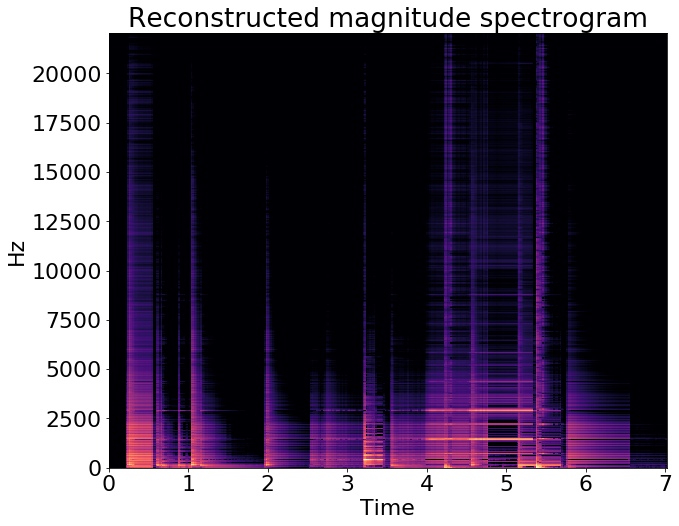

In [41]:
D = librosa.amplitude_to_db((np.matmul(W,H)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr = fs_target, hop_length = n_fft/2)
plt.title("Reconstructed magnitude spectrogram")
plt.show()

## The $i^{th}$ component

The magnitude spectrogram for the $i^{th}$ component is obtained. The complex spectrogram is obtained by performing an elementwise product with the phase of the original audio. We then perform an ISTFT to obtain the time domain signal. We also plot the time domain signals for the purpose of representation.

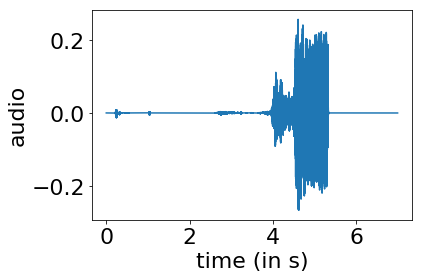

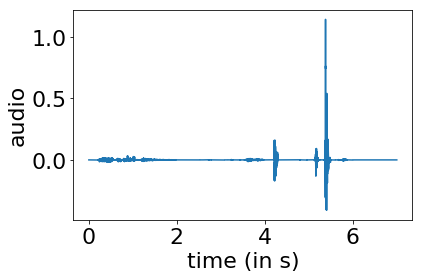

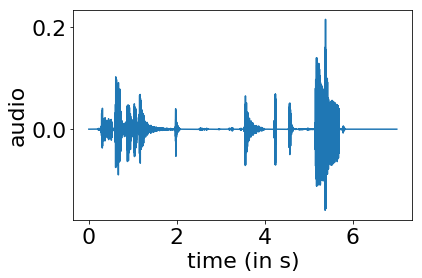

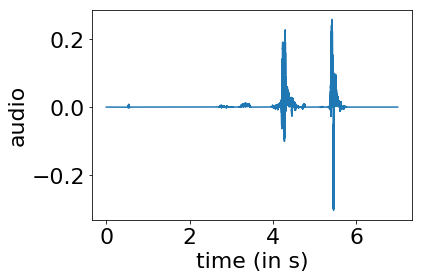

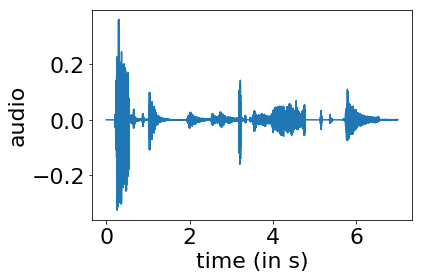

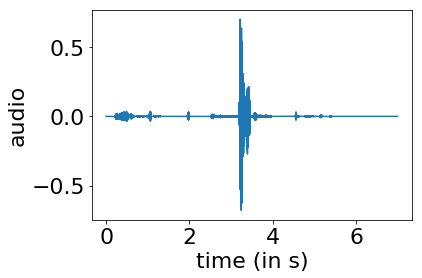

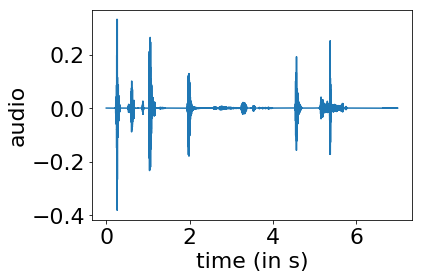

In [46]:
phase = np.angle(mag_spec) # phase of the original signal
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(W)[1]):
    component= np.outer(W[:,i],(H[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    plt.figure()
    plt.plot(x,audio2)
    plt.tight_layout()
    plt.xlabel("time (in s)")
    plt.ylabel("audio")
    plt.show()
    total = total + audio2 
    write("../../source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + ".wav", 44100, audio2)
    audio2_rescaled = audio2/ np.max(audio2)
    write("../../source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + "_rescaled.wav", 44100, audio2_rescaled)

# The reconstructed audio

We superimpose the original time domain signal and the final reconstructed signal.

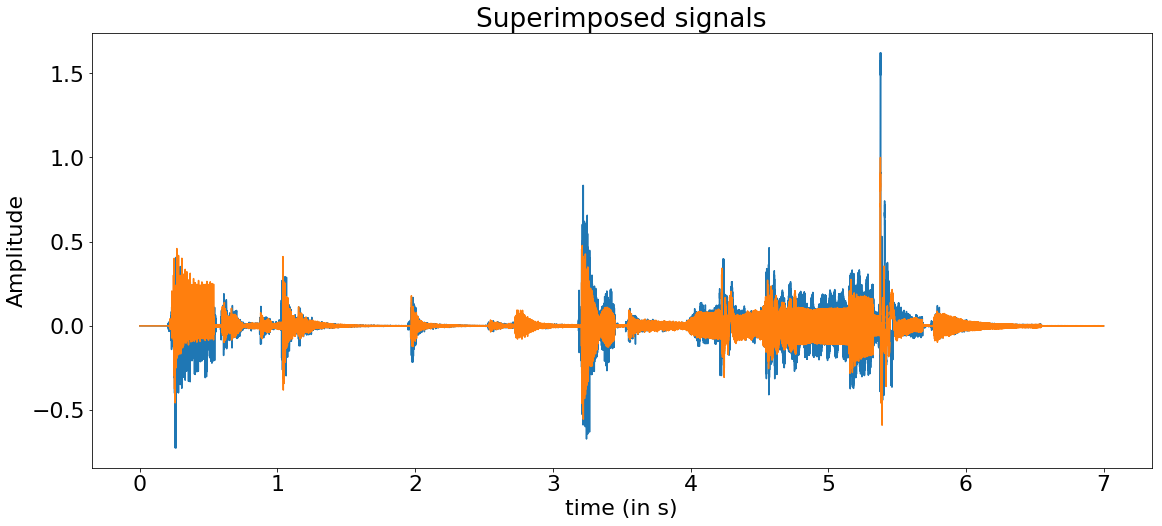

In [47]:
# plotting sum of components and the original signal
plt.figure(figsize = (19,8))
plt.title("Superimposed signals")
plt.xlabel("time (in s)")
plt.ylabel("Amplitude")
plt.plot(x,total)
plt.plot(x,audio)
plt.show()

# Using local implementation

The above code made use of the scikit-learn implementation. Here, we attempt to use the implementation in the file nmf_local.py and check performance. We add a small positive value to the magnitude spectrogram to ensure that we don't run into divisions by zero.

In [48]:
magnitude = np.abs(mag_spec)
nonzero = np.nonzero(magnitude)
minval = (np.min(magnitude[nonzero]))
alpha = minval/1000

In [49]:
corrected = magnitude + alpha

In [50]:
B,G,_ = lstfind(corrected,7,1000,50)

cost after 50 iterations: 204.81399715013038
cost after 100 iterations: 203.39428533173836
cost after 150 iterations: 203.1733801498084
cost after 200 iterations: 203.07255946982295
cost after 250 iterations: 203.02990454750804
cost after 300 iterations: 203.01264256431566
cost after 350 iterations: 203.00395812683053
cost after 400 iterations: 202.98925209180481
cost after 450 iterations: 202.9805082474146
cost after 500 iterations: 202.97058168726207
cost after 550 iterations: 202.95806662761538
cost after 600 iterations: 202.94373668343738
cost after 650 iterations: 202.92859409233975
cost after 700 iterations: 202.91600843635254
cost after 750 iterations: 202.90664315021002
cost after 800 iterations: 202.89969330813395
cost after 850 iterations: 202.8951408912044
cost after 900 iterations: 202.89260708821175
cost after 950 iterations: 202.88989846351154
cost after 1000 iterations: 202.8882532670691


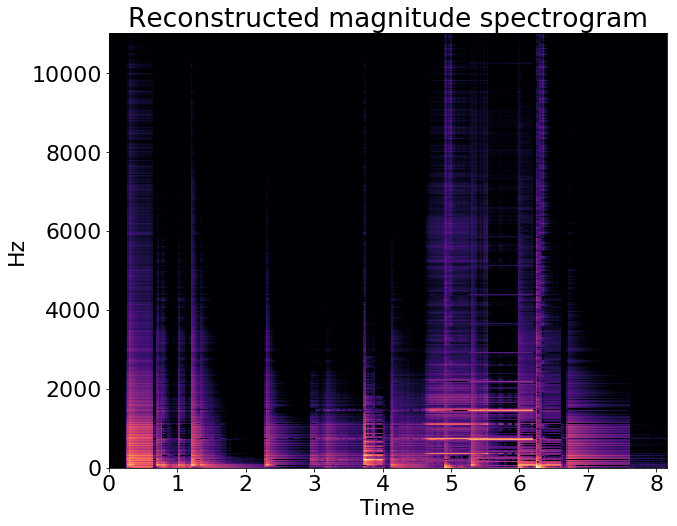

In [51]:
D = librosa.amplitude_to_db((np.dot(B,G)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.title("Reconstructed magnitude spectrogram")
plt.show()

In [52]:
phase = np.angle(mag_spec)
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(B)[1]):
    component= np.outer(B[:,i],(G[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    total = total + audio2 
    audio2_rescaled = audio2/ np.max(audio2)


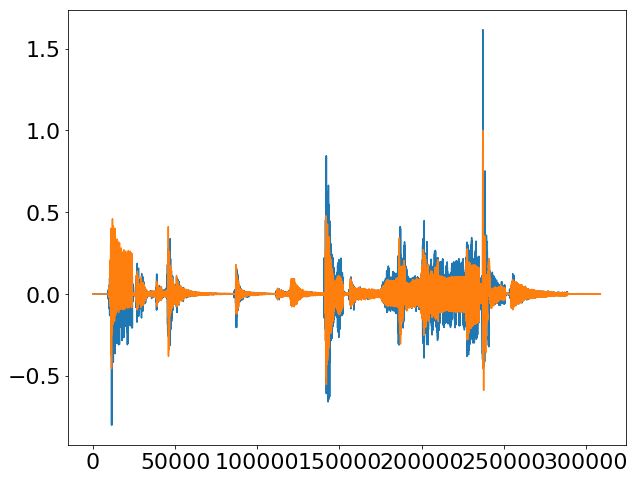

In [53]:
plt.figure(figsize = figsize)

plt.plot(total)
plt.plot(audio)